## Final Project

In [1]:
from zipfile import ZipFile
with ZipFile('/home/workspace/dog-project/food11.zip', 'r') as zf:
    zf.extractall('/home/workspace/dog-project/')

### Importing the packages

In [2]:
% matplotlib inline
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from keras.utils.io_utils import HDF5Matrix

import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Flatten, Dense, Dropout, Activation, Input
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer


from keras.applications import VGG16

from keras.preprocessing import image

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as img

from scipy.misc import imresize

%matplotlib inline

from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict


#### Thought pooling would help in picking up some time

In [4]:
import multiprocessing as mp

num_processes = 6
pool = mp.Pool(processes=num_processes)

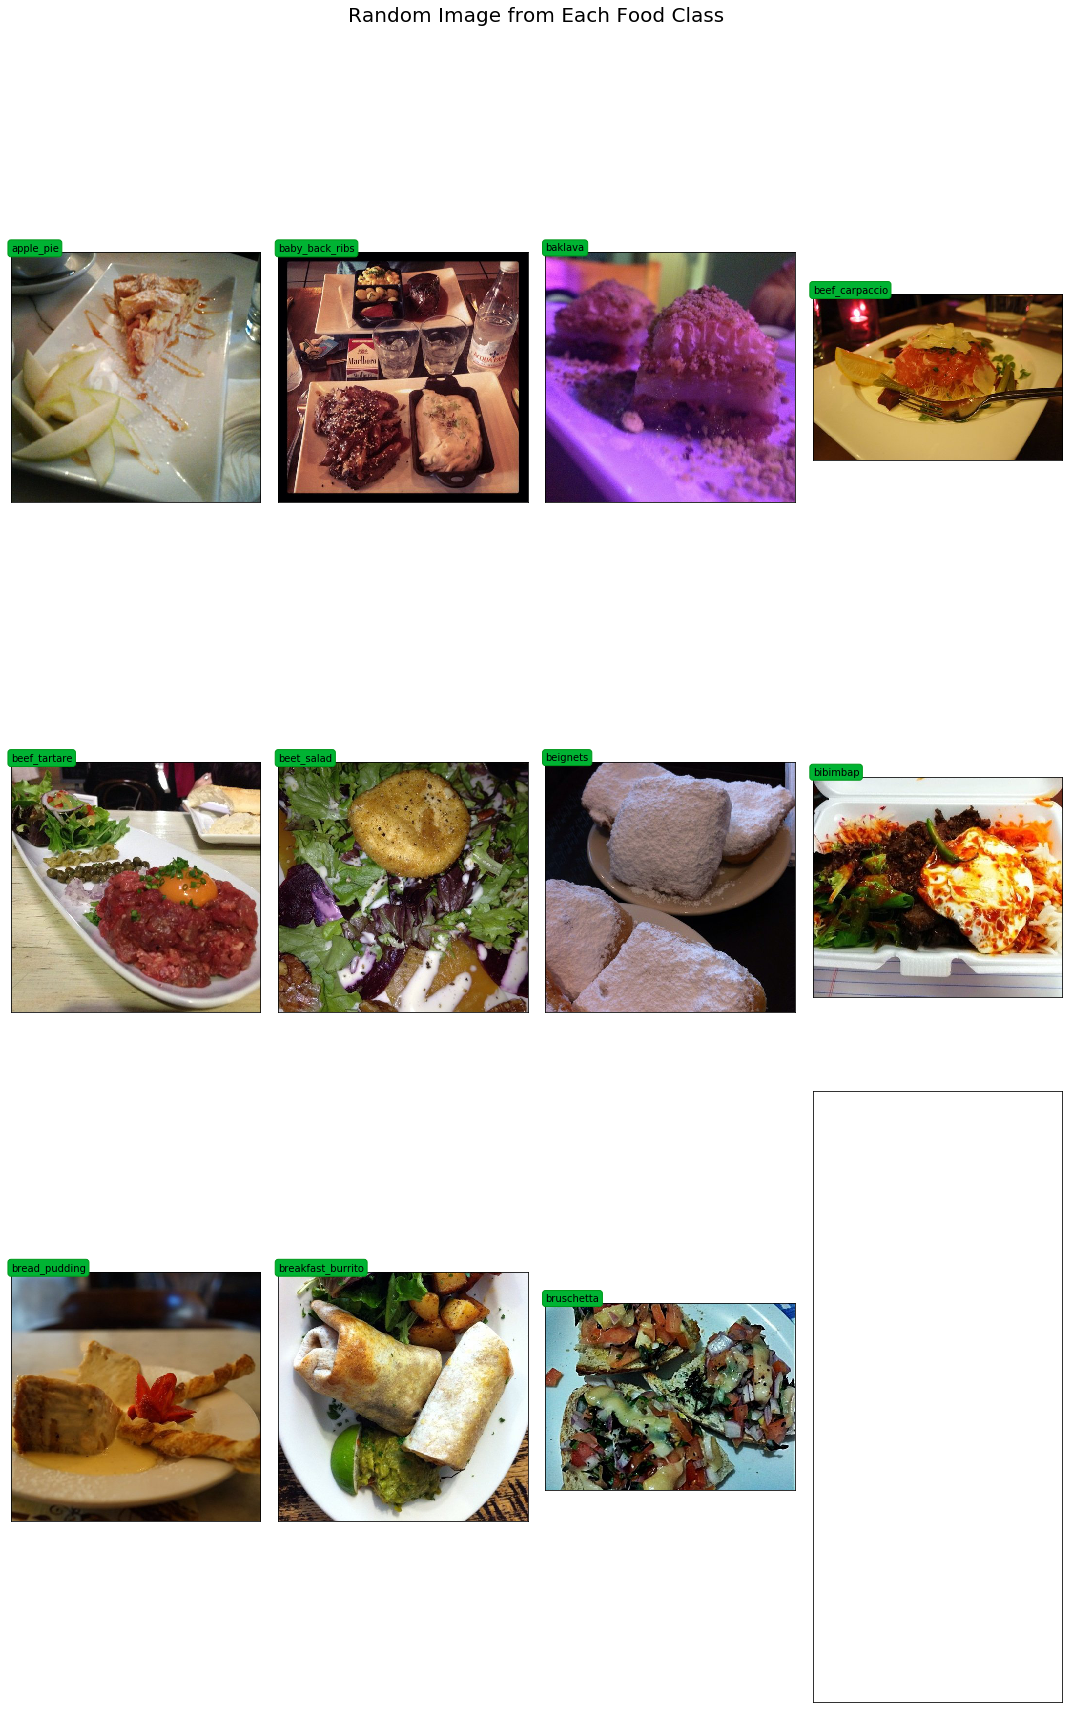

In [5]:
root_dir = './train_sub/'
rows = 3
cols = 4
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#### Loading the images which is in 224*224 format and convering them to np array for further data augumentaion.

#### Setting the hyper parameters and getting data directly from directory.

 So I used this feature in Keras for preprocessing and augmenting the images.5gb of images won't fit in my memory using datagenerator to go across all images.ImageDataGenerator has few parameters to play with the  data augumentaion.Will just check one of them with horizontal_flip = False.I've recaled the values by dividing them by 255.The train_generator functions takes imagegenertor and processes from the directory.Target the image size we want  from the generator.Batch size determines the the number of batches.

In [6]:
from keras import applications
import math
from keras.utils.np_utils import to_categorical  
from keras import backend as K


In [18]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path,shuffle=False)
    food_files = np.array(data['filenames'])
    food_targets = np_utils.to_categorical(np.array(data['target']), 11)
    return food_files, food_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('./train_sub/')
valid_files, valid_targets = load_dataset('./val_sub/')
test_files, test_targets = load_dataset('./test_sub/')

# load list of food names
food_names = [item[20:-1] for item in sorted(glob("./train_sub/*/"))]


# print statistics about the dataset
print('There are %d total food categories.' % len(food_names))
print('There are %s total food images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training food images.' % len(train_files))
print('There are %d validation food images.' % len(valid_files))
print('There are %d test food images.'% len(test_files))



There are 11 total food categories.
There are 10999 total food images.

There are 7235 training food images.
There are 1014 validation food images.
There are 2750 test food images.


In [8]:
#models_filename = 'weights.best.hdf5'
image_dir_train = './train_sub/'
image_dir_test = './test_sub/'
image_dir_val = './val_sub/'

#nb_train_samples = 7235
#nb_validation_samples = 1014

image_size = (224, 224)
batch_size = 16
epochs = 20
#n_classes=11



In [10]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.2,
width_shift_range = 0.1,
height_shift_range=0.1,
rotation_range=0)

train_generator = train_datagen.flow_from_directory(
image_dir_train,
target_size = (224, 224),### the image size we want  from the generator
batch_size = batch_size, 
class_mode = "categorical") ##As we would be using categorical one hot encoded labels 

nb_train_samples = len(train_generator.filenames)  
num_classes = len(train_generator.class_indices)  

val_datagen = ImageDataGenerator(rescale = 1./255)
    
    
    
    


val_generator = val_datagen.flow_from_directory(
        image_dir_val,
        target_size = (image_size[0], image_size[1]), 
        batch_size=batch_size,
        class_mode="categorical")
    
nb_validation_samples = len(val_generator.filenames)  
num_classes = len(val_generator.class_indices)  

predict_size_train = int(math.ceil(nb_train_samples / batch_size))  

test_datagen = ImageDataGenerator(rescale = 1./255)
    
    
test_generator = test_datagen.flow_from_directory(
        image_dir_test,
        target_size = (image_size[0], image_size[1]), 
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False)



Found 7235 images belonging to 11 classes.
Found 1014 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.


In [36]:
def save_bottlebeck_features():
    train_datagen = ImageDataGenerator(rescale = 1./255)
    
   


    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = train_datagen.flow_from_directory(
        image_dir_train,
        target_size = (image_size[0], image_size[1]), 
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    nb_train_samples = len(generator.filenames)  
    num_classes = len(generator.class_indices)  
   
    predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
    
    bottleneck_features_train = model.predict_generator(
        generator,predict_size_train)
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)
    
    val_datagen = ImageDataGenerator(rescale = 1./255)
    
    
    
    


    generator_1 = val_datagen.flow_from_directory(
        image_dir_val,
        target_size = (image_size[0], image_size[1]), 
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    nb_validation_samples = len(generator_1.filenames)  
    num_classes = len(generator_1.class_indices)  
   
    predict_size_val = int(math.ceil(nb_validation_samples / batch_size))  
    
    
    bottleneck_features_validation = model.predict_generator(
        generator_1, predict_size_val)
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)
    
    test_datagen = ImageDataGenerator(rescale = 1./255)
    
    
    generator_2 = test_datagen.flow_from_directory(
        image_dir_test,
        target_size = (image_size[0], image_size[1]), 
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False)
    
    nb_test_samples= len(generator_2.filenames)  
    num_classes = len(generator_2.class_indices)  
   
    predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
    
    
    bottleneck_features_test = model.predict_generator(
        generator_2, predict_size_test)
    np.save(open('bottleneck_features_test.npy', 'wb'),
            bottleneck_features_test)

save_bottlebeck_features()

Found 7235 images belonging to 11 classes.
Found 1014 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.


In [30]:
checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', 
                               verbose=1, save_best_only=True)


model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size,callbacks=[checkpointer], verbose=1)

#model.save_weights('first_try.h5')


Epoch 1/20
452/452 [==============================] - 107s 236ms/step - loss: 1.7601 - acc: 0.4023 - val_loss: 1.7505 - val_acc: 0.3790
Epoch 2/20
452/452 [==============================] - 105s 232ms/step - loss: 1.6470 - acc: 0.4422 - val_loss: 1.8071 - val_acc: 0.3829
Epoch 3/20
452/452 [==============================] - 105s 232ms/step - loss: 1.5748 - acc: 0.4616 - val_loss: 1.7044 - val_acc: 0.3938
Epoch 4/20
452/452 [==============================] - 105s 233ms/step - loss: 1.5140 - acc: 0.4795 - val_loss: 1.5368 - val_acc: 0.4812
Epoch 5/20
452/452 [==============================] - 104s 230ms/step - loss: 1.4938 - acc: 0.4869 - val_loss: 1.5796 - val_acc: 0.4841
Epoch 6/20
452/452 [==============================] - 105s 233ms/step - loss: 1.4491 - acc: 0.5010 - val_loss: 1.4429 - val_acc: 0.5020
Epoch 7/20
452/452 [==============================] - 105s 232ms/step - loss: 1.4035 - acc: 0.5198 - val_loss: 1.7501 - val_acc: 0.4157
Epoch 8/20
452/452 [============================

In [35]:
%%time

model.load_weights('weights.best.hdf5')

preds_test = model.evaluate_generator(test_generator, steps=300)
print("loss:",preds_test[0],"accuracy",preds_test[1])

loss: 1.33352278187 accuracy 0.552521884156
CPU times: user 33.2 s, sys: 1.4 s, total: 34.6 s
Wall time: 31.2 s


In [12]:
train_VGG16 = np.load(open('bottleneck_features_train.npy','rb'))
valid_VGG16=np.load(open('bottleneck_features_validation.npy','rb'))
test_VGG16=np.load(open('bottleneck_features_test.npy','rb'))

In [13]:
print(train_VGG16.shape)
print(valid_VGG16.shape)
print(test_VGG16.shape)

(7235, 7, 7, 512)
(1014, 7, 7, 512)
(2750, 7, 7, 512)


#### Setting horizontal_flip = True

In [14]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [15]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dropout(0.5))
VGG16_model.add(Dense(11, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                5643      
Total params: 5,643
Trainable params: 5,643
Non-trainable params: 0
_________________________________________________________________


In [19]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [36]:
checkpointer = ModelCheckpoint(filepath='weights.best.VGG16_1.hdf5', 
                               verbose=1, save_best_only=True)

history=VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=50, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 7235 samples, validate on 1014 samples
Epoch 1/50
7235/7235 [==============================] - 2s 233us/step - loss: 1.5543 - acc: 0.4775 - val_loss: 1.4848 - val_acc: 0.5108
Epoch 2/50
7235/7235 [==============================] - 2s 235us/step - loss: 1.5651 - acc: 0.4784 - val_loss: 1.5015 - val_acc: 0.5128
Epoch 3/50
7235/7235 [==============================] - 2s 242us/step - loss: 1.5747 - acc: 0.4721 - val_loss: 1.5087 - val_acc: 0.5069
Epoch 4/50
7235/7235 [==============================] - 2s 246us/step - loss: 1.5776 - acc: 0.4665 - val_loss: 1.4993 - val_acc: 0.5217
Epoch 5/50
7235/7235 [==============================] - 2s 249us/step - loss: 1.5788 - acc: 0.4677 - val_loss: 1.4928 - val_acc: 0.5286
Epoch 6/50
7235/7235 [==============================] - 2s 248us/step - loss: 1.5662 - acc: 0.4728 - val_loss: 1.5080 - val_acc: 0.5059
Epoch 7/50
7235/7235 [==============================] - 2s 249us/step - loss: 1.5642 - acc: 0.4670 - val_loss: 1.4820 - val_acc: 0.5207


Epoch 32/50
7235/7235 [==============================] - 2s 245us/step - loss: 1.5515 - acc: 0.4773 - val_loss: 1.4831 - val_acc: 0.5187
Epoch 33/50
7235/7235 [==============================] - 2s 244us/step - loss: 1.5659 - acc: 0.4785 - val_loss: 1.4833 - val_acc: 0.5197
Epoch 34/50
7235/7235 [==============================] - 2s 247us/step - loss: 1.5433 - acc: 0.4813 - val_loss: 1.4768 - val_acc: 0.5197
Epoch 35/50
7235/7235 [==============================] - 2s 250us/step - loss: 1.5720 - acc: 0.4799 - val_loss: 1.4906 - val_acc: 0.5138
Epoch 36/50
7235/7235 [==============================] - 2s 248us/step - loss: 1.5648 - acc: 0.4737 - val_loss: 1.4741 - val_acc: 0.5138
Epoch 37/50
7235/7235 [==============================] - 2s 247us/step - loss: 1.5507 - acc: 0.4811 - val_loss: 1.5034 - val_acc: 0.4990
Epoch 38/50
7235/7235 [==============================] - 2s 247us/step - loss: 1.5562 - acc: 0.4843 - val_loss: 1.4767 - val_acc: 0.5187
Epoch 39/50
7235/7235 [==================

In [37]:
VGG16_model.load_weights('weights.best.VGG16_1.hdf5')

In [38]:
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 56.6545%


In [39]:
def extract_VGG16(tensor):
	from keras.applications.vgg16 import VGG16, preprocess_input
	return VGG16(weights='imagenet', include_top=False).predict(preprocess_input(tensor))



In [40]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    #img = image.load_img(img_path, target_size=(224, 224))
    image_input = plt.imread(img_path)
    image_input = imresize(image_input, (224, 224))
    #print('img',image_input)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(image_input)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

####Plotting few images to see what imagedatagenertor is producing.

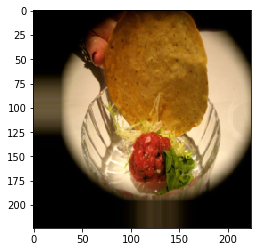

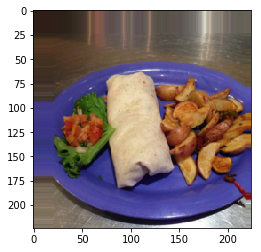

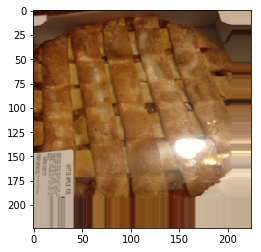

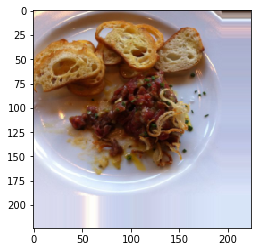

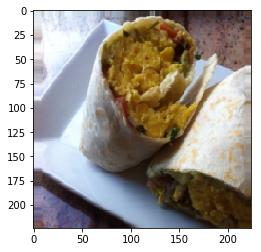

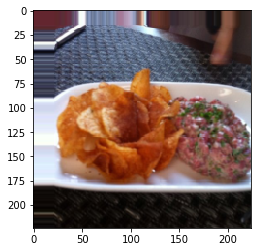

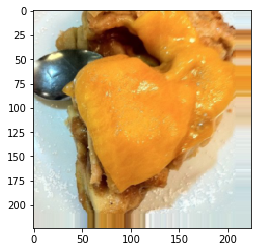

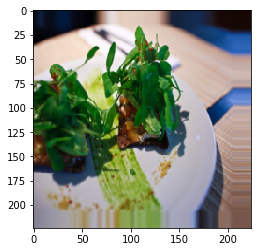

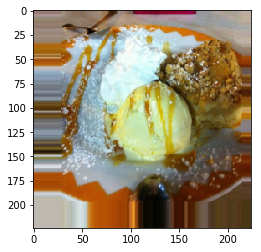

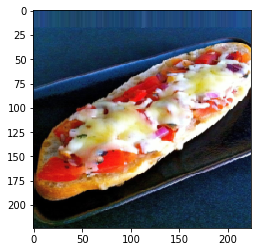

In [29]:
for n in range(10):
    _ = train_generator.next()
    image = (_[0][0]) # take the first image from the batch
    
    plt.imshow(image)
    plt.show()

### The distorted images when the horizontal flip is true

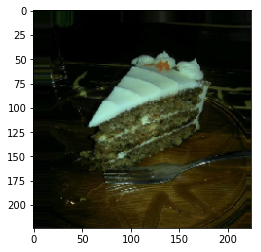

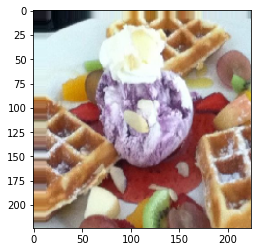

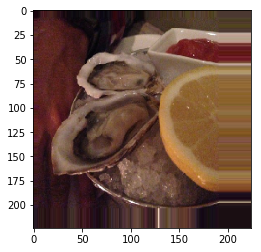

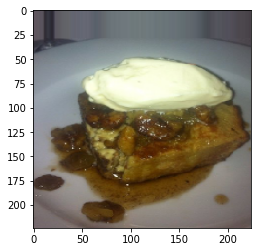

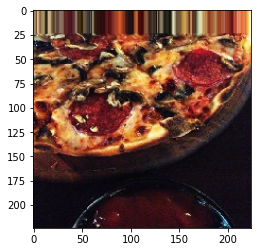

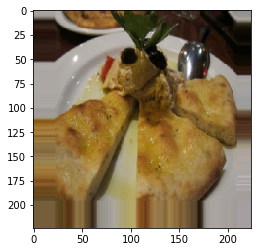

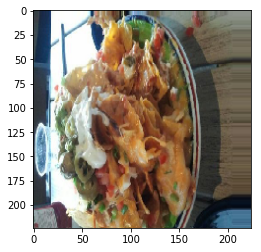

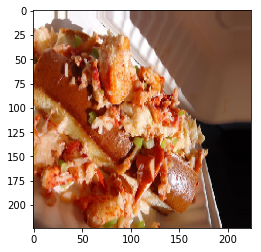

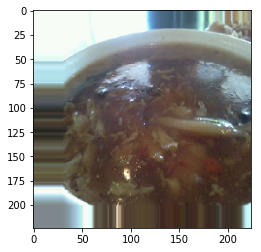

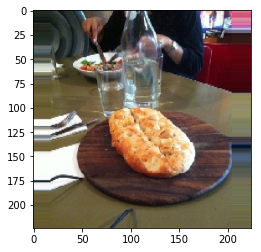

In [33]:
## true
for n in range(10):
    _ = train_generator.next()
    image = (_[0][0]) # take the first image from the batch
    
    plt.imshow(image)
    plt.show()

### The fully connected layers looks like this.

### Evaluating the model for the loss and  accuracy for train data.

### Lets check some random images downloaded from internet.

8
1


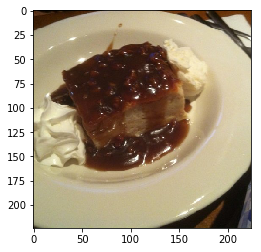

Actual image is is:  bread_pudding

Model predicts its: beef_tartare
10
9


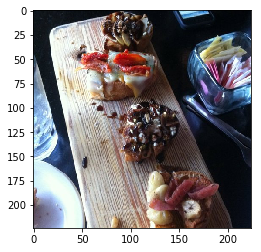

Actual image is is:  bruschetta

Model predicts its: breakfast_burrito
5
5


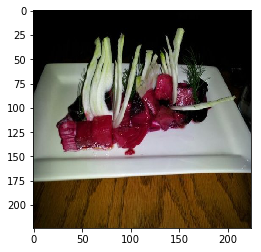

Actual image is is:  beet_salad

Model predicts its: bibimbap
9
2


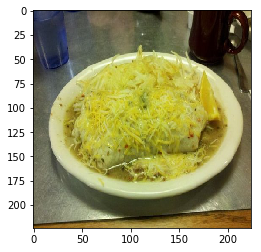

Actual image is is:  breakfast_burrito

Model predicts its: beef_carpaccio
4
3


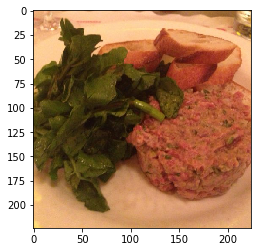

Actual image is is:  beef_tartare

Model predicts its: bread_pudding
8
9


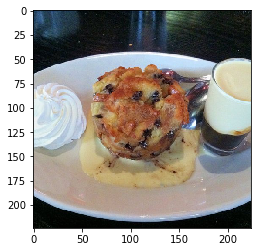

Actual image is is:  bread_pudding

Model predicts its: breakfast_burrito
3
3


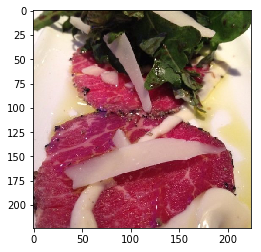

Actual image is is:  beef_carpaccio

Model predicts its: bread_pudding
8
2


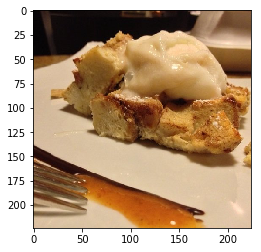

Actual image is is:  bread_pudding

Model predicts its: beef_carpaccio
1
1


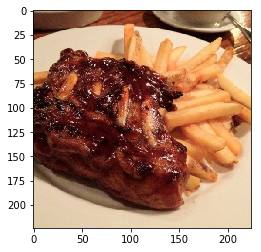

Actual image is is:  baby_back_ribs

Model predicts its: beef_tartare
4
9


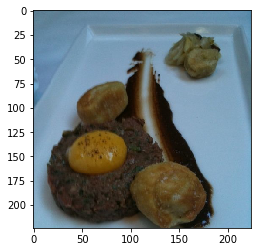

Actual image is is:  beef_tartare

Model predicts its: breakfast_burrito


In [53]:
# # routine for human evaluation - use the generator so we can see how well it can predict
for n in range(10):
    _ = test_generator.next()
    image, classifier = (_[0][0],_[1][0]) # take the first image from the batch
    reverse_index = {}
    for k,v in test_generator.class_indices.items():
        reverse_index[v] = k
    #print(classifier)
    index = np.argmax(classifier)
    print(index)
    answer = reverse_index[index]
    #answer = list(train_generator.class_indices.keys()).[index]
    #print(answer)
    predicted = model.predict(np.array([image]))
    
    predicted_answer_index = np.argmax(predicted[0])
    print(predicted_answer_index)
    predicted_answer = list(test_generator.class_indices.keys())[predicted_answer_index]

    plt.imshow(image)
    plt.show()

    print('Actual image is is: ', answer)
    print()
    print('Model predicts it''s:', predicted_answer)

In [42]:
pic_path = 'food-101/IMG_9495-550x413.jpg'
pic = plt.imread(pic_path)
pic=imresize(pic, (224, 224))
predicted = model_final.predict(np.array([pic]))
predicted_answer_index = np.argmax(predicted[0])
print(predicted_answer_index)
predicted_answer = list(test_generator.class_indices.keys())[predicted_answer_index]
print(predicted_answer)
#print(ix_to_class[predicted_answer])
plt.imshow(pic)

FileNotFoundError: [Errno 2] No such file or directory: 'food-101/IMG_9495-550x413.jpg'

In [43]:
pic_path = 'food-101/329.jpg'
pic = plt.imread(pic_path)
pic=imresize(pic, (224, 224))
predicted = model_final.predict(np.array([pic]))
predicted_answer_index = np.argmax(predicted[0])
print(predicted_answer_index)
predicted_answer = list(test_generator.class_indices.keys())[predicted_answer_index]
print(predicted_answer)
#print(ix_to_class[predicted_answer])
plt.imshow(pic)

FileNotFoundError: [Errno 2] No such file or directory: 'food-101/329.jpg'

In [44]:
pic_path = 'food-101/download.jpeg'
pic = plt.imread(pic_path)
#print(pic)
pic=imresize(pic, (224, 224))
predicted = model_final.predict(np.array([pic]))
predicted_answer_index = np.argmax(predicted[0])
print(predicted_answer_index)
predicted_answer = list(test_generator.class_indices.keys())[predicted_answer_index]
print(predicted_answer)
#print(ix_to_class[predicted_answer])
plt.imshow(pic)

FileNotFoundError: [Errno 2] No such file or directory: 'food-101/download.jpeg'

### Conclusion

Future enhancements to the project would be developing a mobile app with deep learning and classify real pictures on the go.Transfer learning was very useful to complete my project on time.But would like to explore more real world problems and deep dive into Deep Learning like participating in data science hackathon and Kaggle competitions.



References:
    
https://pdfs.semanticscholar.org/9c1c/4e6ab238f34bef0348b04bfed78cda11e9ed.pdf

http://cs231n.stanford.edu/reports/2017/pdfs/19.pdf

https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model.

In [45]:
vgg16 = VGG16(include_top=False, weights='imagenet')
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________